# Practical 3

# Your tasks

1. Run the code in the notebook. During the practical session, be prepared to discuss the methods and answer the questions from this notebook:

    * When applied to a new, test instance bagging classifier aggregates the predictions of all predictors and estimates the statistical mode. Is this similar to the hard or the soft voting strategy?
    * [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) automatically performs soft voting when the base classifier can estimate class probabilities (i.e., has a `predict_proba()` method). Which strategy – hard or soft voting – does `BaggingClassifier` follow with the `DecisionTreeClassifier` as the base classifier?
    * What do the feature importance weights obtained on the *iris* dataset suggest? Are they similar to your observations from the previous experiments on this dataset?
    * We said earlier than one of the advantages of bagging and pasting strategies is that predictors can all be trained in parallel. Is the same applicable to AdaBoost?
    * One of the hyperparameters of the boosting algorithms is learning_rate. What is it responsible for and what effect on the resulting ensemble does it have?
    * What generalisation behaviour can you expect from each of the tree regressor ensembles (using different learning rates and different number of estimators – see above)?

2. Apply ensemble techniques of your choice to one of the datasets you've worked on during the previous practicals and report your findings.

3. **Optional**: If you want more practice with these techniques, try implementing a [*stacking algorithm*](https://en.wikipedia.org/wiki/Ensemble_learning#Stacking). There is no available implementation of this approach in `sklearn` so it needs to be implemented from scratch. The idea is as follows:
    * Split a dataset of your choice into three subsets – training, validation and test.
    * Train a number of predictors on the training data and apply them to the validation data.
    * Treat the predictions of those predictors on the validation data to generate new training set: you can use the predictions of the estimators as new features (i.e., each training instance will have as many features as the number of predictors you originally used), and the validation data targets as the new training instances targets. 
    * Now train a *blender* – a classifier of your choice – on the new training data created this way. Together with the original classifiers, the blender forms a stacking ensemble.
    * Finally, apply your original classifiers to the test set, feed their predictions to the blender, and use blender's output as the prediction on the test set.

# Task 1
- When applied to a new, test instance bagging classifier aggregates the predictions of all predictors and estimates the statistical mode. Is this similar to the hard or the soft voting strategy?

** Answer ** Hard, since we choose the most frequent prediction.
    
- [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) automatically performs soft voting when the base classifier can estimate class probabilities (i.e., has a `predict_proba()` method). Which strategy – hard or soft voting – does `BaggingClassifier` follow with the `DecisionTreeClassifier` as the base classifier?

**Answer**: DecisionTreeClassifier has predict_proba() method, hence we're dealing with soft voting

- What do the feature importance weights obtained on the *iris* dataset suggest? Are they similar to your observations from the previous experiments on this dataset?

**Answer**: They suggest that the petal is a more definitory factor in classification.

- We said earlier than one of the advantages of bagging and pasting strategies is that predictors can all be trained in parallel. Is the same applicable to AdaBoost?

**Answer**: No, since each predictor depends on the previous one, so the training has to be don sequentially.

- One of the hyperparameters of the boosting algorithms is learning_rate. What is it responsible for and what effect on the resulting ensemble does it have?

**Answer**: The learning rate scales the contribution of each tree: the lower the rate, the more trees we ned to include in the ensemble, with the predictions generalising better. 


- What generalisation behaviour can you expect from each of the tree regressor ensembles (using different learning rates and different number of estimators – see above)?
**Answer**: As we see above, the first regressor with learning_rate = 1 and 3 trees is underfitting the data, but the 2nd one is overfitting it. We see below that the best result is in the middle, with only 68 trees, so I would expect the 2 regressors to perform poorly when exposed to new data in a similar fashion




# Task 2

Apply ensemble techniques of your choice to one of the datasets you've worked on during the previous practicals and report your findings.

In [ ]:
Setup

In [1]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

## Simple voting classifiers: hard and soft voting strategies

- a sufficient number of weak learners, and
- their decisions are sufficiently diverse.

In [2]:
from sklearn import datasets
digits = datasets.load_digits()
list(digits.keys())

['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR']

In [4]:
X, y = digits["data"], digits["target"]
X.shape

(1797, 64)

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
split.get_n_splits(X, y)
print(split)       

for train_index, test_index in split.split(X, y):
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.2,
            train_size=None)
TRAIN: 1437 TEST: 360
(1437, 64) (1437,) (360, 64) (360,)


The code below shows how to apply several classifiers to this data.The point here is that we are combining *diverse* classifiers in an ensemble: in essence, `RandomForestClassifier` runs recursive partitioning on the data, while `Support Vector Machines` try to construct a linear boundary between the classes (as discussed in Lecture 3)

In [6]:
from sklearn.ensemble import VotingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC # Support Vector Machines

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

Let's look into how correlated the predictions of the classifiers are: first, get the predictions on the test data, next store them as a `pandas` DataFrame, and finally apply `.corr()` function:

In [7]:
import pandas as pd

def get_predictions(clf):
    clf.fit(X_train, y_train)
    return clf.predict(X_test)


preds = {'lr': get_predictions(log_clf), 
        'rf': get_predictions(rnd_clf), 
        'svc': get_predictions(svm_clf)}
df = pd.DataFrame(data=preds)
df[:100]

,lr,rf,svc
0,5,5,5
1,2,2,2
2,8,8,8
3,8,1,1
4,7,7,7
...,...,...,...
95,2,2,2
96,7,7,7
97,8,8,8
98,4,4,4


In [8]:
df.corr()

,lr,rf,svc
lr,1.000000,0.946742,0.947750
rf,0.946742,1.000000,0.970502
svc,0.947750,0.970502,1.000000


### Hard voting
Will this correlation in the individual classifiers' predictions be sufficient for an ensemble? Let's check this out by combining the votes with a *hard voting strategy*: the ensemble classifier will simply choose the majority class predicted by the three classifiers.

The code below prints out individual classifiers' accuracy scores along with the ensemble's accuracy score:

In [9]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.9583333333333334
RandomForestClassifier 0.9611111111111111
SVC 0.9916666666666667
VotingClassifier 0.9833333333333333


**Observation:** SVC did better than the voting classifier

### Soft voting 

`SVC` classifier doesn't estimate class probabilities by default, so you need to set the `probability` hyperparameter to `True`.


In [10]:
log_clf = LogisticRegression(random_state=42) # estimate class probabilities by default
rnd_clf = RandomForestClassifier(random_state=42) # estimate class probabilities by default
svm_clf = SVC(probability=True, random_state=42) # estimate class probabilities with True 

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

Now let's estimate the accuracy of the voting classifier in this mode:

In [11]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.9583333333333334
RandomForestClassifier 0.9611111111111111
SVC 0.9916666666666667
VotingClassifier 0.9805555555555555


**Observation**: Despite using a soft voting strategy which is supposed to give more weight to the individual classifiers with higher accuracies, the final soft VotingClassifier performs slightly worse than the hard one

## Bagging ensembles: bagging and pasting

Let's use `sklearn's BaggingClassifier` to train an ensemble of $500$ [`Decision Trees`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), each trained on $100$ training instances randomly selected from the training set with replacement (for bagging, but you can change the strategy to pasting by setting `bootstrap` to `False`). In addition, both bagging and pasting strategies are good for parallelisation: predictors can all be trained in parallel on different CPU cores or even different servers. Setting `n_jobs` parameter to $-1$ tells `sklearn` to use all available CPU cores:

In [12]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

#use bootstrap=False for pasting
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
#n_jobs = use all of the available CPU cores
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

Let's calculate the accuracy score for the bagging classifier that combines $500$ Decision Tree estimators with a prediction of a single Decision Tree trained on the same data:

In [13]:
print(accuracy_score(y_test, y_pred))

0.9222222222222223


In [14]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.825


### Out-of-Bag evaluation

In [17]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9498956158663883

This means that the bagging classifier is likely to achieve around $95\%$ accuracy on the test data, too. Let's check the results:

In [18]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9305555555555556

Close! 

Take a look into the decision process by printing out the predictions of the classifier on the training instances.

In [20]:
bag_clf.oob_decision_function_

array([[0.09042553, 0.07978723, 0.01595745, ..., 0.        , 0.2712766 ,
        0.38297872],
       [0.98333333, 0.        , 0.        , ..., 0.        , 0.        ,
        0.01666667],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.41361257, 0.0052356 , 0.0104712 , ..., 0.05235602, 0.06806283,
        0.21465969],
       [0.00588235, 0.        , 0.        , ..., 0.94705882, 0.01764706,
        0.        ],
       [0.        , 0.04069767, 0.02325581, ..., 0.02906977, 0.04069767,
        0.34302326]])

## Random Forests

[`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) is an ensemble of Decision Trees typically trained via the bagging method. The number of training instances (`max_samples`) is usually set to the total size of the training set. So, in fact, `RandomForestClassifier` will be roughly equivalent to the `BaggingClassifier` that takes Decision Trees as base estimators with the following parameters:

In [21]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

The key difference is that, rather than using `BaggingClassifier` and passing it a `DecisionTreeClassifier`, you can rely on the `sklearn's RandomForestClassifier` implementation, which is more convenient and optimised for Decision Trees:

In [22]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, 
                                 n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

Let's estimate the difference between the two classifiers' predictions:

In [23]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # see to what extent predictions are identical

0.9388888888888889

### Feature importance

Another useful property of the Random Forests classifier is that it can help you measure the relative importance of each feature by looking at how much the tree nodes that use this particular feature reduce impurity of the nodes on average (i.e., across all trees in the forest). The results are scaled so that the sum of all feature importances is equal to $1$.


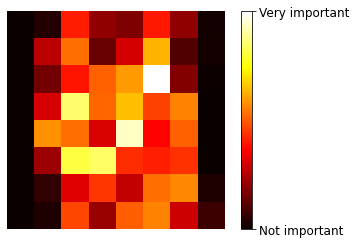

In [24]:
from sklearn import datasets
digits = datasets.load_digits()

rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(digits["data"], digits["target"])
def plot_digit(data):
    image = data.reshape(8, 8)
    plt.imshow(image, cmap = matplotlib.cm.hot,
               interpolation="nearest")
    plt.axis("off")
    
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

## AdaBoost

*Boosting*, or *hypothesis boosting* is an ensemble method that can combine several weak learners into a strong learner. The general idea is to train predictors sequentially in such a way that each next predictor tries to correct its predecessor. The most popular among boosting methods are *AdaBoost* (which stands for *Adaptive Boosting*) and *Gradient Boosting*. Let's apply *AdaBoost* first.

The idea behind *AdaBoost* is as follows: in order to correct the predecessor's mistakes, the algorithm assigns higher weights to the training instances that the predecessor underfitted. I.e., the next step pays more attention to such instances and the algorithm focuses more on the hard cases.

Here is the step-by-step strategy:
- start with the first classifier (i.e., this can be a Decision Trees classifier)
- train it and use it to make predictions on the training set
- increase the relative weight of misclassified training instances
- train a second classifier with these new updated weights and make new predictions
- update weights using the new predictions
- continue until stopping criteria are satisfied.

In [26]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

Here is the full list of parameters and attributes of the algorithm:

In [28]:
list(m for m in dir(ada_clf) if not m.startswith("_") and m.endswith("_"))

['base_estimator_',
 'classes_',
 'estimator_errors_',
 'estimator_weights_',
 'estimators_',
 'feature_importances_',
 'n_classes_',
 'n_features_in_']

E.g., you can check classification errors for each estimator in the boosted ensemble as follows:

In [29]:
ada_clf.estimator_errors_

array([0.80097425, 0.77877399, 0.76556079, 0.76784349, 0.79536663,
       0.75803658, 0.75632757, 0.78008056, 0.78725409, 0.75427787,
       0.77933258, 0.77230468, 0.80442323, 0.78589353, 0.78081672,
       0.79615547, 0.80218109, 0.81377651, 0.79147006, 0.74990234,
       0.81283776, 0.78063383, 0.77181485, 0.75637328, 0.80925024,
       0.76877274, 0.78305977, 0.78316466, 0.80707849, 0.79110479,
       0.79390387, 0.76385776, 0.75897325, 0.8183144 , 0.79292414,
       0.7823857 , 0.75721273, 0.81507925, 0.76643509, 0.78479321,
       0.77038703, 0.82162682, 0.77058078, 0.75786408, 0.75900907,
       0.80816434, 0.77250513, 0.78096649, 0.78050773, 0.82345498,
       0.78252747, 0.76422285, 0.76184596, 0.81559969, 0.77168095,
       0.78831008, 0.78137069, 0.80636622, 0.80652607, 0.77803365,
       0.7811047 , 0.74199013, 0.77271518, 0.76447835, 0.75185125,
       0.76041115, 0.77187425, 0.79060624, 0.76522733, 0.75418758,
       0.74838979, 0.71661483, 0.74982378, 0.73616979, 0.69118

## Gradient Boosting

Gradient Boosting is another popular boosting algorithm. It also works sequentially adding new predictors to the ensemble, each one correcting the errors from its predecessor. Unlike AdaBoost, it's trying to fit each new predictor to the *residual errors* made by the previous predictor. 


Next, let's fit a single [`DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html):

In [36]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2, random_state=42)

Now train a second `DecisionTreeRegressor` on the residual errors made by the first predictor:

In [37]:
y2 = y_train - tree_reg1.predict(X_train)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X_train, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

Finally, let's train a third regressor on the residual errors made by the second predictor:

Finally, let's train a third regressor on the residual errors made by the second predictor:

In [38]:
y3 = y2 - tree_reg2.predict(X_train)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X_train, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

Just built an ensemble containing three trees. It can now be applied to new instances by making predictions based on adding up the predictions from all three trees:

In [39]:
y_pred = sum(tree.predict(X_test) for tree in (tree_reg1, tree_reg2, tree_reg3))

y_pred

array([ 8.28764437,  5.04560255,  6.30426495,  7.34461479,  5.76629421,
        2.0144583 ,  5.04560255,  3.38732798,  6.08595238,  6.30426495,
        0.70006663,  5.24335295,  9.54630677,  4.7130827 ,  5.04560255,
        5.24335295,  4.50763181,  3.66503238,  8.48539477,  6.91477469,
        4.50763181,  2.76828665,  8.28764437,  2.76828665,  3.05480814,
        5.24335295,  5.04560255,  0.70006663,  5.25650013,  3.58507838,
        6.08595238,  9.54630677,  4.50763181,  6.08595238,  4.50763181,
        4.50763181,  5.24335295,  6.08595238,  0.70006663,  8.28764437,
        2.76828665,  3.80863649,  6.91477469,  4.50763181,  6.30426495,
        5.24335295,  5.24335295,  3.46728198,  9.54630677,  5.24335295,
        4.50763181,  1.50962425,  5.24335295,  5.24335295,  5.04560255,
        3.38732798,  2.0806368 ,  0.70006663,  4.50763181, -0.87055345,
        7.9679862 ,  2.2783872 ,  6.08595238,  3.80863649,  4.7130827 ,
        9.54630677,  5.04560255,  6.08595238,  4.72594438,  4.50

A simpler way to train ensembles of *Gradient Boosted Regression Trees* is to use [`sklearn's GradientBoostingRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) implementation. In addition to the typical hyperparameters that control the growth of the trees, it also includes hyperparameters that control the ensemble training, e.g. `n_estimators`:

In [46]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X_train, y_train)
y_pred = gbrt.predict(X_test)
y_pred

array([ 8.28764437,  5.04560255,  6.30426495,  7.34461479,  5.76629421,
        2.0144583 ,  5.04560255,  3.38732798,  6.08595238,  6.30426495,
        0.70006663,  5.24335295,  9.54630677,  4.7130827 ,  5.04560255,
        5.24335295,  4.50763181,  3.66503238,  8.48539477,  6.91477469,
        4.50763181,  2.76828665,  8.28764437,  2.76828665,  3.05480814,
        5.24335295,  5.04560255,  0.70006663,  5.25650013,  3.58507838,
        6.08595238,  9.54630677,  4.50763181,  6.08595238,  4.50763181,
        4.50763181,  5.24335295,  6.08595238,  0.70006663,  8.28764437,
        2.76828665,  3.80863649,  6.91477469,  4.50763181,  6.30426495,
        5.24335295,  5.24335295,  3.46728198,  9.54630677,  5.24335295,
        4.50763181,  1.50962425,  5.24335295,  5.24335295,  5.04560255,
        3.38732798,  2.0806368 ,  0.70006663,  4.50763181, -0.87055345,
        7.9679862 ,  2.2783872 ,  6.08595238,  3.80863649,  4.7130827 ,
        9.54630677,  5.04560255,  6.08595238,  4.72594438,  4.50

In [47]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X_train, y_train)
y_pred = gbrt_slow.predict(X_test)
y_pred

array([ 7.35895865,  4.51829824,  5.75315756,  4.80321222,  5.55639636,
        2.69048886,  5.88604093,  2.33405955,  6.42725096,  5.05489882,
       -0.28768336,  5.39020486,  8.28733763,  5.56905071,  5.50418408,
        5.0676613 ,  2.39335412,  4.4962902 ,  9.39923963,  5.42334091,
        5.89258629,  3.62117368,  7.51386256,  0.69505292,  3.48098645,
        6.00593153,  4.12698593,  2.31115204,  5.61310284,  3.7222933 ,
        6.78417047,  6.98097237,  4.79283027,  5.98337452,  5.46264371,
        5.63953086,  4.46557414,  6.05260543, -0.33318674,  9.18171176,
        3.00238531,  4.6902385 ,  6.23504058,  5.29277334,  5.67022626,
        5.55261842,  5.1723993 ,  2.29734098,  8.36884886,  4.80073954,
        1.76468473,  1.52559302,  5.05463184,  4.85940594,  4.85846744,
        1.7412035 ,  2.81092055,  0.36327708,  0.98146289,  0.59283957,
        6.90013143,  5.0152344 ,  6.49715797,  2.62763294,  4.06137369,
        7.69931304,  5.21195631,  6.10536628,  7.07609797,  1.47

### Gradient Boosting with Early Stopping

The examples above demonstrate ensembles with a different number of estimators. Which one is better? How can you quantitatively estimate the optimal number of predictors?

One technique that you can use is called *early stopping* – it allows your algorithm to stop as soon as the validation error reaches a minimum. An easy way to implement this with `sklearn` is to use `staged_predict()` method as the code below demonstrates:

In [50]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=100)
X, y = digits["data"], digits["target"]

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
split.get_n_splits(X, y)
print(split)       

for train_index, test_index in split.split(X, y):
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y[train_index], y[test_index]

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.2,
            train_size=None)
TRAIN: 1437 TEST: 360


GradientBoostingRegressor(max_depth=2, n_estimators=117, random_state=42)

In [54]:
bst_n_estimators # optimal number of trees

117

Finally, an alternative to training a large number of estimators and then looking back in order to find the optimal number of those is to allow the algorithm to stop training when the validation error does not improve over a number of consecutive iterations (e.g., $5$ in the code below). For that to work, set the `warm_start` to `True`:

In [56]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

print(gbrt.n_estimators)

119
